In [1]:
import os, re, magic, shutil
from glob import glob
import time, datetime
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
import torchvision
import torchvision.models as models

#from skimage import io
import sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn import metrics, preprocessing
import albumentations as A
import albumentations.pytorch

In [2]:
CFG = {
    'img_size': 260,
    'bs': 64,
    'seed': 0,
    'device': 'cuda:0',
    'model' : 'resnet152',
    'model_dir': '/KD_resnet152_16classes_202305190006/',
    'num_workers': 8
}


In [3]:
classes16 = ["10Kwalk","battery",'box','else','bottle','handkerchief',
              'milk', 'paper', 'pet','plug','receipt', 'shopping bag', 'stairs',
             'transportation', 'trash picking', 'dishes']

classes19 = ["10Kwalk","battery",'box','else','toothcup', 'tumbler','handkerchief',
              'milk', 'paper', 'pet','plug','receipt', 'shopping bag', 'stairs',
             'transportation', 'trash picking', 'green dish','leftover','wrap']
dishes_class = ['wrap','leftover','green dish']
box_class = ["box","untapedBox"]
pet_class = ["unlabeled","labeled"]
bottle_class = ["toothcup","tumbler"]


In [4]:
# TEST DATASET DATAFRAME
label_list = classes16
test_path = '../Data/carbon_reduction_data/test/'
test_img_paths = []
test_img_labels = []

for label in label_list: ## 각 레이블 돌기
    print(f'label: {label}',end=' ')
    img_paths = [] 
    img_labels = []
    dir_path = test_path + label ## 레이블 폴더 경로
    
    for folder, subfolders, filenames in os.walk(dir_path): ## 폴더 내 모든 파일 탐색
        for img in filenames: ## 각 파일 경로, 레이블 저장
            img_paths.append(folder+'/'+img)
            img_labels.append(label)
        
    print(len(img_paths))

    test_img_paths.extend(img_paths)
    test_img_labels.extend(img_labels)

print('Test_Images: ',len(test_img_paths))
print("Test_Images_labels:", len(test_img_labels))

label: 10Kwalk 489
label: battery 702
label: box 1969
label: else 946
label: bottle 1539
label: handkerchief 609
label: milk 594
label: paper 417
label: pet 1734
label: plug 733
label: receipt 211
label: shopping bag 429
label: stairs 1016
label: transportation 559
label: trash picking 407
label: dishes 1339
Test_Images:  13693
Test_Images_labels: 13693


##### label list for labelencoding

In [5]:
label_list

['10Kwalk',
 'battery',
 'box',
 'else',
 'bottle',
 'handkerchief',
 'milk',
 'paper',
 'pet',
 'plug',
 'receipt',
 'shopping bag',
 'stairs',
 'transportation',
 'trash picking',
 'dishes']

In [7]:
## Pandas 데이터프레임 만들기
tst_df = pd.DataFrame(test_img_paths, columns=['image_id'])
tst_df['dir'] = tst_df['image_id'].apply(lambda x: os.path.dirname(x))
tst_df['image_id'] = tst_df['image_id'].apply(lambda x: os.path.basename(x))
tst_df['label'] = test_img_labels
test = tst_df

In [9]:
le = preprocessing.LabelEncoder()
m = le.fit_transform(label_list)
#m = le.transform(test['label'].values)
# test['label'] = le.transform(test['label'].values)
# test
m

array([ 0,  1,  3,  5,  2,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,  4])

In [116]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
def get_img(path, sub_path=None):
    try:
        im_bgr = cv2.imread(path)
        im_rgb = im_bgr[:, :, ::-1]
        past_path = path
    except: ## 이미지 에러 발생 시 백지로 대체
        im_bgr = cv2.imread('../Data/carbon_reduction/temp_img.jpg')
        im_rgb = im_bgr[:, :, ::-1]
    return im_rgb

transform_test = A.Compose([
    A.Resize(height = CFG['img_size'], width = CFG['img_size']),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0),
    A.pytorch.transforms.ToTensorV2()
        ])

class CustomDataset(Dataset):
    def __init__(
        self, df, data_root, transform=transform_test):
        
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transform = transform
        self.data_root = data_root
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
          
        path = "{}/{}".format(self.data_root[index], self.df.iloc[index]['image_id'])
        img  = get_img(path)
        
        if self.transform:
            img = self.transform(image=img)['image']
            
        return img 


In [117]:
# # LOAD PRE-TRAINED MODEL
# class Model(nn.Module):
#     def __init__(self, model_arch, num_classes= 2,pretrained=True):
#         super(Model, self).__init__()
#         self.backbone = models.mobilenet_v3_large(pretrained=pretrained) ## 모델 선언 여기 models.##(pretrained =pretrained)
#         self.backbone.classifier[-1] = nn.Linear(self.backbone.classifier[-1].in_features, num_classes)
        
#     def forward(self, x):
#         x = self.backbone(x)
#         return x

In [118]:
# LOAD PRE-TRAINED MODEL
class Model(nn.Module):
    def __init__(self, model_arch_str, num_classes= 2,pretrained=True):
        super(Model, self).__init__()
        model_arch = getattr(models, model_arch_str)
        self.backbone = model_arch(pretrained=pretrained) ## 모델 선언 여기 models.##(pretrained =pretrained)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)
        
    def forward(self, x):
        x = self.backbone(x)
        return x

In [119]:
def inference(model, data_loader, device):
    model.eval()
    image_preds_all = []
    total_inference_time = 0  # Keep track of the total inference time
    
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    for step, (imgs) in pbar:
        imgs = imgs.to(device).float()
        start_time = time.time()  # Start timing here
        image_preds = model(imgs)   #output = model(input)
        end_time = time.time()  # End timing here
        
        inference_time = end_time - start_time  # Inference time for this batch
        total_inference_time += inference_time  # Add it to the total
        
        image_preds_all += [torch.softmax(image_preds, 1).detach().cpu().numpy()]
        
    image_preds_all = np.concatenate(image_preds_all, axis=0)
    
    average_inference_time = total_inference_time / len(data_loader.dataset)  # Average over all images
    time_in_milliseconds = average_inference_time * 1000  # This would be approximately 0.2979 milliseconds
    
    print(f"Average inference time per image: {time_in_milliseconds} milliseconds")
    return image_preds_all

In [120]:
# RUN INFERENCE
model = Model(CFG['model'], len(label_list), pretrained=True)
load_model = './models/' + CFG['model_dir'] + CFG['model'] + '.pth'
test_dir = test.dir.values

tst_ds = CustomDataset(test, test_dir, transform=transform_test)
tst_loader = torch.utils.data.DataLoader(
    tst_ds, 
    batch_size=CFG['bs'],
    num_workers=CFG['num_workers'],
    shuffle=False,
    pin_memory=True
)
device = torch.device(CFG['device'])

# INFERENCE VIA MULTI-GPU
# if torch.cuda.device_count() > 1:
#         model = nn.DataParallel(model)
model.to(device)

# RUN INFERENCE
predictions = []
model.load_state_dict(torch.load(load_model))
with torch.no_grad():
    predictions += [inference(model, tst_loader, device)]


predictions = np.mean(predictions, axis=0) 
test['pred'] = np.argmax(predictions, axis=1)


/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|█████████████████████████████████████████| 214/214 [04:02<00:00,  1.13s/it]

Average inference time per image: 0.42293779184704566 milliseconds


In [121]:
test['label'] = le.inverse_transform(test['label'].values)
test['pred'] = le.inverse_transform(test['pred'].values)
test

,image_id,dir,label,pred
0,0282.jpg,../Data/carbon_reduction_data/test/10Kwalk,10Kwalk,10Kwalk
1,0466.jpg,../Data/carbon_reduction_data/test/10Kwalk,10Kwalk,10Kwalk
2,0190.jpg,../Data/carbon_reduction_data/test/10Kwalk,10Kwalk,10Kwalk
3,0234.jpg,../Data/carbon_reduction_data/test/10Kwalk,10Kwalk,10Kwalk
4,0392.jpg,../Data/carbon_reduction_data/test/10Kwalk,10Kwalk,10Kwalk
...,...,...,...,...
13688,0381.jpg,../Data/carbon_reduction_data/test/dishes/wrap,dishes,dishes
13689,0236.jpg,../Data/carbon_reduction_data/test/dishes/wrap,dishes,dishes
13690,0384.jpg,../Data/carbon_reduction_data/test/dishes/wrap,dishes,dishes
13691,0074.jpg,../Data/carbon_reduction_data/test/dishes/wrap,dishes,dishes


accuracy: 0.9609
f1_score: 0.9575


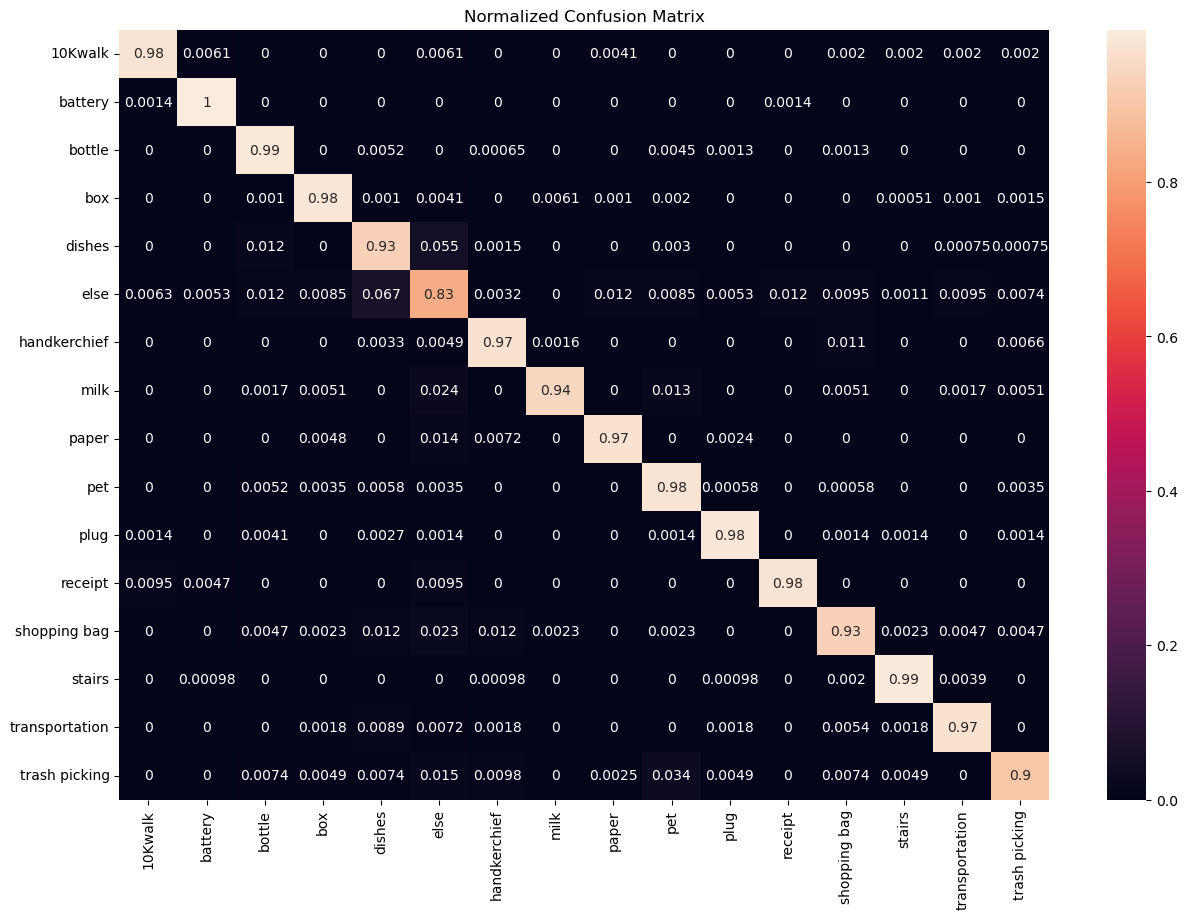

In [122]:
import seaborn as sns

test_acc = np.sum(test.label == test.pred) / len(test)
test_matrix = confusion_matrix(test['label'], test['pred'])
epoch_f1 = f1_score(test['label'], test['pred'], average='macro')
print(f'accuracy: {test_acc:.4f}')
print(f'f1_score: {epoch_f1:.4f}')

test_matrix = confusion_matrix(test['label'], test['pred'], normalize='true')
#test_matrix = confusion_matrix(test['label'], test['pred'])

plt.figure(figsize = (15,10))
sns.heatmap(test_matrix, 
            annot=True, 
            xticklabels = sorted(set(label_list)), 
            yticklabels = sorted(set(label_list)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

#print(f'confusion_matrix \n-------------------------\n {test_matrix}')